This notebook finds polynomial fits to the Heger and Woosley 2010 radiation data for Pop III stars, computing two 3 degree polynomial fits to the total photon counts as a function of stellar mass (one for M < 35, one for M > 35) for photons in the HI, HeI, and HeII ionization bins, and the IR, FUV, and LW bins. Also computes a single 3 degree polynomial fit for the HI, HeI, and HeII photon energies, but leaves the rest of the bands as constant values. 

These fits do well (typical errors in the 0.1% range and maximal errors in the few percent range for a few cases). However, the FUV and IR (particularly IR) have large errors due to the significant non-monotonic behavior of the model photon counts at the larger masses. On average -- however -- this yields similar IMF-integrated total photon counts even if the individual counts over / underestimate for a given star at high mass.

Comes with a routine to print the fits out to be copied into a C++ code (namely Star_ComputePhotonRates.C in Enzo)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from astropy import constants as const
from astropy import units as u


from scipy.optimize import curve_fit

from galaxy_analysis.plot.plot_styles import *
def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return



In [51]:


#
# load up the ionization data from HW 2010. This is split between two tables
#
ionization_data = np.genfromtxt('HW2010_table1_ionization_rates_energy.dat',
                                skip_header=5,
                                dtype= [('mass','f8'),
                                        ('E_HI'  ,'f8'), ('N_HI'  ,'f8'),('lambda_HI'  ,'f8'),
                                        ('E_HeI' ,'f8'), ('N_HeI' ,'f8'),('lambda_HeI' ,'f8'),
                                        ('E_HeII','f8'), ('N_HeII','f8'),('lambda_HeII','f8'),
                                        ('E_LW'  ,'f8'), ('N_LW'  ,'f8'),('lambda_LW'  ,'f8'),                                        
                                       ]                              
                               )

colors = { 'HI' : 'C0', 'HeI' : 'C1', 'HeII' : 'C2', 'LW' : 'C3', "IR" : "C4", "FUV":"C5"}


#
# This table contains the binned photon counts needed to compute the IR and FUV 
#
binned_photon_data = np.genfromtxt("HW2010_table2_photon_bins.dat", skip_header=5,
                                   dtype = [('mass','f8'),
                                             ('bin1','f8'),
                                             ('bin2','f8'),
                                             ('bin3','f8'),
                                             ('bin4','f8'),('bin5','f8'),('bin6','f8'),
                                             ('bin7','f8'),('bin8','f8')])

band_bins = {'IR' : 'bin1', 'FUV' : 'bin2'}

In [3]:
# from pop3_properties.F in Enzo

#
# Model lifetime used in Enzo for popIII stars. this is used to compare rates
# with the previous enzo model
#

popIII_lifetimes = np.array([6.190e7,4.536e7,3.366e7,2.560e7,
          2.022e7,1.673e7,1.443e7,1.288e7,
          1.181e7,1.102e7,1.040e7,9.853e6,
          9.357e6,8.907e6,8.494e6,8.114e6,
          7.762e6,7.432e6,7.122e6,6.829e6,
          6.549e6,6.281e6,6.024e6,5.779e6,
          5.548e6,5.329e6,5.124e6,4.931e6,
          4.752e6,4.587e6,4.434e6,4.294e6,
          4.168e6,4.054e6,3.953e6,3.864e6,
          3.788e6,3.723e6,3.668e6,3.622e6,
          3.585e6,3.554e6,3.529e6,3.510e6,
          3.496e6,3.486e6,3.480e6,3.476e6,
          3.474e6,3.473e6,3.473e6,3.474e6,
          3.474e6,3.472e6,3.469e6,3.464e6,
          3.456e6,3.444e6,3.431e6,3.414e6,
          3.396e6,3.376e6,3.354e6,3.331e6,
          3.306e6,3.280e6,3.254e6,3.227e6,
          3.199e6,3.172e6,3.144e6,3.117e6,
          3.090e6,3.063e6,3.037e6,3.012e6,
          2.988e6,2.965e6,2.943e6,2.921e6,
          2.901e6,2.881e6,2.863e6,2.844e6,
          2.827e6,2.811e6,2.795e6,2.779e6,
          2.765e6,2.751e6,2.737e6,2.724e6,
          2.712e6,2.700e6,2.688e6,2.677e6,
          2.667e6,2.656e6,2.647e6,2.637e6,
          2.628e6,2.619e6,2.611e6,2.603e6,
          2.595e6,2.587e6,2.580e6,2.573e6,
          2.566e6,2.559e6,2.552e6,2.546e6,
          2.539e6,2.533e6,2.527e6,2.521e6,
          2.515e6,2.509e6,2.503e6,2.498e6,
          2.492e6,2.486e6,2.481e6,2.475e6,
          2.470e6,2.464e6,2.459e6,2.454e6,
          2.448e6,2.443e6,2.438e6,2.433e6,
          2.428e6,2.423e6,2.418e6,2.414e6,
          2.409e6,2.404e6,2.400e6,2.395e6,
          2.390e6,2.386e6,2.381e6,2.377e6,
          2.373e6,2.368e6,2.364e6,2.360e6,
          2.356e6,2.352e6,2.348e6,2.344e6,
          2.340e6,2.336e6,2.332e6,2.328e6,
          2.324e6,2.320e6,2.317e6,2.313e6,
          2.309e6,2.306e6,2.302e6,2.299e6,
          2.295e6,2.292e6,2.288e6,2.285e6,
          2.282e6,2.278e6,2.275e6,2.272e6,
          2.269e6,2.266e6,2.262e6,2.259e6,
          2.256e6,2.253e6,2.250e6,2.247e6,
          2.244e6,2.242e6,2.239e6,2.236e6,
          2.233e6,2.230e6,2.228e6,2.225e6,
          2.222e6,2.219e6,2.217e6,2.214e6,
          2.212e6,2.209e6,2.207e6,2.204e6,
          2.202e6,2.199e6,2.197e6,2.194e6,
          2.192e6,2.189e6,2.187e6,2.185e6,
          2.182e6,2.180e6,2.178e6,2.176e6,
          2.174e6,2.171e6,2.169e6,2.167e6,
          2.165e6,2.163e6,2.161e6,2.159e6,
          2.157e6,2.155e6,2.153e6,2.151e6,
          2.149e6,2.147e6,2.145e6,2.143e6,
          2.141e6,2.139e6,2.137e6,2.135e6,
          2.134e6,2.132e6,2.130e6,2.128e6,
          2.127e6,2.125e6,2.123e6,2.122e6,
          2.120e6,2.118e6,2.117e6,2.115e6,
          2.113e6,2.112e6,2.110e6,2.109e6,
          2.107e6,2.106e6,2.104e6,2.103e6,
          2.101e6,2.100e6,2.098e6,2.097e6,
          2.095e6,2.094e6,2.093e6,2.091e6,
          2.090e6,2.088e6,2.087e6,2.086e6,
          2.085e6,2.083e6,2.082e6,2.081e6,
          2.079e6,2.078e6,2.077e6,2.076e6,
          2.075e6,2.073e6,2.072e6,2.071e6,
          2.070e6,2.069e6,2.068e6,2.066e6,
          2.065e6,2.064e6,2.063e6,2.062e6,
          2.061e6,2.060e6,2.059e6,2.058e6,
          2.057e6,2.056e6,2.055e6,2.054e6,
          2.053e6,2.052e6,2.051e6,2.050e6,
          2.049e6,2.048e6,2.047e6,2.046e6,
          2.045e6,2.044e6,2.043e6,2.042e6,
          2.041e6,2.041e6,2.040e6,2.039e6,
          2.038e6,2.037e6,2.036e6,2.035e6,
          2.035e6,2.034e6,2.033e6,2.032e6,
          2.031e6,2.030e6,2.030e6,2.029e6,
          2.028e6,2.027e6,2.027e6,2.026e6,
          2.025e6,2.024e6,2.023e6,2.023e6,
          2.022e6,2.021e6,2.020e6,2.020e6,
          2.019e6,2.018e6,2.018e6,2.017e6,
          2.016e6,2.015e6,2.015e6,2.014e6,
          2.013e6,2.013e6,2.012e6,2.011e6,
          2.011e6,2.010e6,2.009e6,2.009e6,
          2.008e6,2.007e6,2.006e6,2.006e6,
          2.005e6,2.004e6,2.004e6,2.003e6,
          2.002e6,2.002e6,2.001e6,2.001e6,
          2.000e6,1.999e6,1.999e6,1.998e6,
          1.997e6,1.997e6,1.996e6,1.995e6,
          1.995e6,1.994e6,1.993e6,1.993e6,
          1.992e6,1.991e6,1.991e6,1.990e6,
          1.989e6,1.989e6,1.988e6,1.987e6,
          1.987e6,1.986e6,1.986e6,1.985e6,
          1.984e6,1.984e6,1.983e6,1.982e6,
          1.982e6,1.981e6,1.980e6,1.980e6,
          1.979e6,1.978e6,1.977e6,1.977e6,
          1.976e6,1.975e6,1.975e6,1.974e6,
          1.973e6,1.973e6,1.972e6,1.971e6,
          1.970e6,1.970e6,1.969e6,1.968e6,
          1.968e6,1.967e6,1.966e6,1.965e6,
          1.965e6,1.964e6,1.963e6,1.962e6,
          1.962e6,1.961e6,1.960e6,1.959e6,
          1.959e6,1.958e6,1.957e6,1.956e6,
          1.956e6,1.955e6,1.954e6,1.953e6,
          1.953e6,1.952e6,1.951e6,1.950e6,
          1.950e6,1.949e6,1.948e6,1.947e6,
          1.946e6,1.946e6,1.945e6,1.944e6,
          1.943e6,1.943e6,1.942e6,1.941e6,
          1.940e6,1.940e6,1.939e6,1.938e6,
          1.937e6,1.936e6,1.936e6,1.935e6,
          1.934e6,1.933e6,1.933e6,1.932e6,
          1.931e6,1.930e6,1.929e6,1.929e6,
          1.928e6,1.927e6,1.926e6,1.926e6,
          1.925e6,1.924e6,1.923e6,1.922e6,
          1.922e6,1.921e6,1.920e6,1.919e6,
          1.919e6,1.918e6,1.917e6,1.916e6,
          1.916e6,1.915e6,1.914e6,1.913e6,
          1.913e6,1.912e6,1.911e6,1.910e6,
          1.910e6,1.909e6,1.908e6,1.908e6,
          1.907e6,1.906e6,1.905e6,1.905e6,
          1.904e6,1.903e6,1.903e6,1.902e6,
          1.901e6,1.900e6,1.900e6,1.899e6,
          1.898e6,1.898e6,1.897e6,1.896e6,
          1.896e6,1.895e6,1.894e6,1.894e6,
          1.893e6,1.892e6,1.892e6,1.891e6,
          1.890e6,1.890e6,1.889e6,1.888e6,
          1.888e6,1.887e6,1.886e6,1.886e6,
          1.885e6,1.884e6,1.884e6,1.883e6,
          1.883e6,1.882e6,1.881e6,1.881e6,
          1.880e6,1.880e6,1.879e6,1.878e6,
          1.878e6,1.877e6,1.877e6,1.876e6,
          1.875e6,1.875e6,1.874e6,1.874e6,
          1.873e6,1.873e6,1.872e6,1.871e6,
          1.871e6,1.870e6,1.870e6,1.869e6,
          1.869e6,1.868e6,1.868e6,1.867e6,
          1.867e6,1.866e6,1.865e6,1.865e6,
          1.864e6,1.864e6,1.863e6,1.863e6,
          1.862e6,1.862e6,1.861e6,1.861e6,
          1.860e6,1.860e6,1.859e6,1.859e6,
          1.858e6,1.858e6,1.857e6,1.857e6,
          1.856e6,1.856e6,1.855e6,1.855e6,
          1.854e6,1.854e6,1.853e6,1.853e6,
          1.853e6,1.852e6,1.852e6,1.851e6,
          1.851e6,1.850e6,1.850e6,1.849e6,
          1.849e6,1.848e6,1.848e6,1.848e6,
          1.847e6,1.847e6,1.846e6,1.846e6,
          1.845e6,1.845e6,1.845e6,1.844e6,
          1.844e6,1.843e6,1.843e6,1.843e6,
          1.842e6,1.842e6,1.841e6,1.841e6,
          1.841e6,1.840e6,1.840e6,1.839e6,
          1.839e6,1.839e6,1.838e6,1.838e6,
          1.837e6,1.837e6,1.837e6,1.836e6,
          1.836e6,1.836e6,1.835e6,1.835e6,
          1.834e6,1.834e6,1.834e6,1.833e6,
          1.833e6,1.833e6,1.832e6,1.832e6,
          1.832e6,1.831e6,1.831e6,1.831e6,
          1.830e6,1.830e6,1.830e6,1.829e6,
          1.829e6,1.829e6,1.828e6,1.828e6,
          1.828e6,1.827e6,1.827e6,1.827e6,
          1.826e6,1.826e6,1.826e6,1.826e6,
          1.825e6,1.825e6,1.825e6,1.824e6,
          1.824e6,1.824e6,1.824e6,1.823e6,
          1.823e6,1.823e6,1.822e6,1.822e6,
          1.822e6,1.822e6,1.821e6,1.821e6,
          1.821e6,1.820e6,1.820e6,1.820e6,
          1.820e6,1.819e6,1.819e6,1.819e6,
          1.819e6,1.818e6,1.818e6,1.818e6,
          1.818e6,1.817e6,1.817e6,1.817e6,
          1.817e6,1.816e6,1.816e6,1.816e6,
          1.816e6,1.815e6,1.815e6,1.815e6,
          1.815e6,1.815e6,1.814e6,1.814e6,
          1.814e6,1.814e6,1.813e6,1.813e6,
          1.813e6,1.813e6,1.813e6,1.812e6,
          1.812e6,1.812e6,1.812e6,1.812e6,
          1.811e6,1.811e6,1.811e6,1.811e6,
          1.811e6,1.810e6,1.810e6,1.810e6,
          1.810e6,1.810e6,1.810e6,1.809e6,
          1.809e6,1.809e6,1.809e6,1.809e6,
          1.808e6,1.808e6,1.808e6,1.808e6,
          1.808e6,1.808e6,1.807e6,1.807e6,
          1.807e6,1.807e6,1.807e6,1.807e6,
          1.807e6,1.806e6,1.806e6,1.806e6,
          1.806e6,1.806e6,1.806e6,1.805e6,
          1.805e6,1.805e6,1.805e6,1.805e6,
          1.805e6,1.805e6,1.805e6,1.804e6,
          1.804e6,1.804e6,1.804e6,1.804e6,
          1.804e6,1.804e6,1.803e6,1.803e6,
          1.803e6,1.803e6,1.803e6,1.803e6,
          1.803e6,1.803e6,1.803e6,1.802e6,
          1.802e6,1.802e6,1.802e6,1.802e6,
          1.802e6,1.802e6,1.802e6,1.802e6,
          1.801e6,1.801e6,1.801e6,1.801e6,
          1.801e6,1.801e6,1.801e6,1.801e6,
          1.801e6,1.801e6,1.801e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.797e6,
          1.797e6,1.797e6,1.797e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.798e6,1.798e6,1.798e6,1.798e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.799e6,
          1.799e6,1.799e6,1.799e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6,
          1.800e6,1.800e6,1.800e6,1.800e6]) # in yr
    
popIII_lifetime_masses = np.linspace(5,1000,np.size(popIII_lifetimes))    


def get_popIII_lifetime(m):
    """
    Interpolate popIII lifetime masses exactly as is done in pop3_maker.F
    
    returns lifetime in years
    """
    
    if np.size(m) > 1:
        lifetimes = np.zeros(np.size(m))
        
        for i,mass in enumerate(m):
            lifetimes[i] = popIII_lifetimes[np.argmin(np.abs(popIII_lifetime_masses-mass))]
        return lifetimes
    else:
        index = np.argmin(np.abs(popIII_lifetime_masses)-m)
        return popIII_lifetimes[index]
    

In [4]:
# the previous photon rate model in Enzo

def schaerer_photon_rates(m, radtype):
    
    x  = np.log10(m)
    x2 = x*x
    
    rate = np.zeros(np.size(m))
    
    select = (m > 9.0)*(m<500.0)    
   
    if radtype == 'HI':
        rate[select]   = 10.0**(43.61 + 4.9*x[select]   - 0.83*x2[select])
    elif radtype == 'HeI':
        rate[select]   = 10.0**(42.51 + 5.69*x[select]-1.01*x2[select])
    elif radtype == 'HeII':
        rate[select] = 10.0**(26.71 + 18.14*x[select]-3.58*x2[select])
    elif radtype == 'LW':
        rate[select] = 10.0**(44.03 + 4.59*x[select] - 0.77*x2[select])
        
    select = (m > 5.0)*(m < 9.0)
    
    if radtype == 'HI':
        rate[select] = 10.0**(39.29+8.55*x[select])
    elif radtype=='HeI':
        rate[select] = 10.0**(29.24+18.49*x[select])
    elif radtype=='HeII':
        rate[select] = 10.0**(26.71+18.14*x[select]-3.58*x2[select])
    elif radtype=='LW':
        rate[select] = 10.0**(44.03+4.59*x[select]-0.77*x2[select])

    return rate

def schaerer_total_photons(m, radtype):
    """
    Combine schaerer rates with popIII lifetimes to get total count
    """
    
    return schaerer_photon_rates(m,radtype) * (get_popIII_lifetime(m)*u.yr).to('s').value


# not really from Schaerer but old energies we used:
schaerer_energy = {'HI' : 28.0, 'HeI' : 50.0, 'HeII' : 58.0, 'LW' : 12.8}

In [86]:

class FitData:
    
    def __init__(self, x, y, logx=True, logy=True):
        """
        Class to simplify fitting polynomials to the datatsets
        """
        
        self.x = x
        self.y = y
        
        self.logx=logx
        self.logy=logy
        
        if self.logx:
            self._fitx = np.log10(x)
        else:
            self._fity = 1.0*self.x
            
        if self.logy:
            self._fity = np.log10(y)
        else:
            self._fity = 1.0*self.y
        
        
        self.params = None
        
        return
    
    def generate_polyfit(self, deg = 2, cut = None):
        """
        Generate polynomial fits of specified degree. If 
        cut is provided, splits data x domain at that cut value
        and fits multiple polynomials. Multiple cuts can be provided
        as a list, and N_cut+1 fits will be made.
        """
                
        if cut is None:
            self.deg    = [deg]
            self.cut    = None
            self.params = [np.polyfit(self._fitx, self._fity, deg = self.deg[0])]
            
        else:
            
            if np.size(cut) == 1:
                self.deg = [deg,deg]
                self.cut = [cut]
            else:
                if np.size(deg) == 1:
                    self.deg = [deg] * (np.size(cut)+1)
                else:
                    self.deg = deg
                self.cut = cut
                            
            cutmin = np.min(self.x)
            cutmax = self.cut[0]
            
            self.params = [None]*(np.size(self.cut)+1)
            
            for i in np.arange(np.size(self.cut)+1):
                
                select = (self.x>=cutmin) * (self.x < cutmax)
                
                self.params[i] = np.polyfit(self._fitx[select], 
                                            self._fity[select], deg=self.deg[i])
                
                cutmin = cutmax*1.0
                
                if i >= (np.size(self.cut) - 1):
                    cutmax = np.max(self.x)*1.0001
                else:
                    cutmax = self.cut[i+1]
                    
        
        self.error    = (self.y - self.evaluate(self.x)) / self.y
        self.abserror = np.abs(self.error)
        
        self.maxerror     = np.max(self.abserror)
        self.avgerror     = np.average(self.abserror)
        
        return
    
    def evaluate(self, xvals):
        """
        Once fit, evaluate
        """
        
        if self.params is None:
            print("No fit made yet")
            raise RuntimeError
        
        result = np.zeros(np.size(xvals))
        
        if self.logx:
            result_x = np.log10(xvals)
        else:
            result_x = 1.0*xvals
        
        if self.cut is None:
            for i,c in enumerate(self.params[0]):
                result += c * result_x**(self.deg[0]-i)
        else:
            
            cutmin = np.min( [np.min(self.x),np.min(xvals)])
            cutmax = self.cut[0]
            
            for j in np.arange(len(self.cut)+1):
                
                select = (xvals>=cutmin)*(xvals<cutmax)
                
                for i,c in enumerate(self.params[j]):
            
                    result[select] += c * result_x[select]**(self.deg[0]-i)
                
                
                cutmin = 1.0*cutmax
                if j >= len(self.cut) - 1:
                    cutmax = np.max(self.x)*1.0001
                else:
                    cutmax = self.cut[j+1]                
        
        return 10.0**result
    
    
    def output_to_code(self, fit_only = None, end='\n'):
        """
        print out polynomial fit(s) in a way that can be copy-pasted
        to c++
        """
        
        if fit_only is None:
            print("%i polynomial fits made"%(len(self.params)))
        
            if not (self.cut is None):
                cutmin = np.min(self.x)
                cutmax = self.cut[0]        
            
                for i in np.arange(np.size(self.cut)+1):
                    print("%i degree over the range %5.5E <= x < %5.5E"%(self.deg[i],cutmin,cutmax))
                
                    cutmin = cutmax*1.0
                
                    if i >= (np.size(self.cut) - 1):
                        cutmax = np.max(self.x)*1.0001
                    else:
                        cutmax = self.cut[i+1]
        
            output_params = self.params
        else:
            output_params = [self.params[fit_only]]
        
        
        for j, p in enumerate(output_params):
            if self.logy:
                print("= pow(10.0, ",end='')
            else:
                print("= (",end='')
                
            for i, c in enumerate(p):
                
                if self.deg[j]-i == 0:
                    print(" %5.4e"%(c),end='')
                elif self.deg[j]-i == 1:
                    print(" %5.4e*x"%(c), end = '')                    
                else:
                    print(" %5.4e*x%i"%(c, self.deg[j]-i), end = '')
                
                if i < np.size(p) - 1:
                    if p[i+1] > 0:
                        print(" +",end='')
                
                    
            print(");",end=end)
            
        return
    


In [87]:
#
# generate fits
# 

all_fits = {}    

degree = 3
cut    = 35 # for photon rates


for radtype in ['HI','HeI','HeII','LW']:
    
    all_fits['N_'+radtype] = FitData(ionization_data['mass'], ionization_data['N_'+radtype])
    all_fits['N_'+radtype].generate_polyfit(deg=degree, cut = cut)

    photon_energy = (const.h * const.c/(ionization_data['lambda_' + radtype]*u.Angstrom)).to('eV')    
    all_fits['E_'+radtype] = FitData(ionization_data['mass'], photon_energy.value)
    all_fits['E_'+radtype].generate_polyfit(deg=degree,cut=None)
    
for radtype in ['IR',"FUV"]:
    
    all_fits["N_" + radtype] = FitData(binned_photon_data['mass'], binned_photon_data[band_bins[radtype]])
    all_fits["N_" + radtype].generate_polyfit(deg=degree,cut=cut)
    

                                       
    

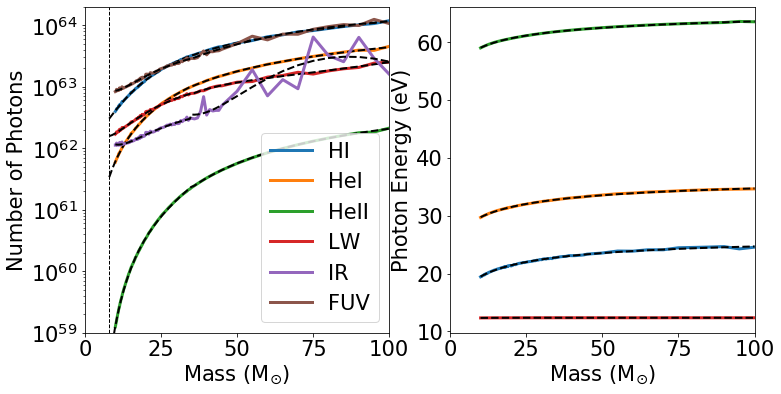

In [78]:
plot_settings()
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

plot_schaerer = False

for radtype in ['HI','HeI','HeII','LW','IR','FUV']:
    
    if radtype == 'IR' or radtype == 'FUV':
        ax[0].plot(binned_photon_data['mass'], binned_photon_data[band_bins[radtype]],
                   lw = 3, color = colors[radtype], label = radtype)
        ax[0].plot(binned_photon_data['mass'], 
               all_fits['N_'+radtype].evaluate(binned_photon_data['mass']), lw = 2, 
               color = 'black', ls = '--')    
        
        
        
        
    else:
        ax[0].plot(ionization_data['mass'], 
               ionization_data['N_' + radtype], lw = 3, 
               color = colors[radtype], label = radtype)
        
        masses = np.linspace(8.0,100.0,100)
        
        ax[0].plot(masses, 
               all_fits['N_'+radtype].evaluate(masses), lw = 2, 
               color = 'black', ls = '--') 
        
        if plot_schaerer:
            mass = np.linspace(5.0,500.0,1000)    
            ax[0].plot(mass, schaerer_total_photons(mass, radtype),
                   lw = 3, color = colors[radtype], ls = ':')
            
        #
        # second panel. Photon energy
        #
        photon_energy = (const.h * const.c/(ionization_data['lambda_' + radtype]*u.Angstrom)).to('eV')
    
        ax[1].plot(ionization_data['mass'], photon_energy.value, lw = 3,
                   color = colors[radtype])
     

        ax[1].plot(ionization_data['mass'], all_fits['E_'+radtype].evaluate(ionization_data['mass']), lw = 2,
                     ls ='--', color = 'black')
    
        if plot_schaerer:
            mass = np.linspace(1.0,500.0,1000)
            ax[1].plot(mass, np.ones(np.size(mass))*schaerer_energy[radtype], 
                   lw = 3, color = colors[radtype], ls = ':')     

 

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[0].set_ylabel(r'Number of Photons')
ax[1].set_ylabel(r'Photon Energy (eV)')


ax[0].legend(loc='best')

ax[0].semilogy()
#ax[0].semilogx()

ax[0].set_ylim(1.0E59,2.0E64)

ax[0].plot([8.0,8.0],ax[0].get_ylim(),lw=1,color='black',ls='--')

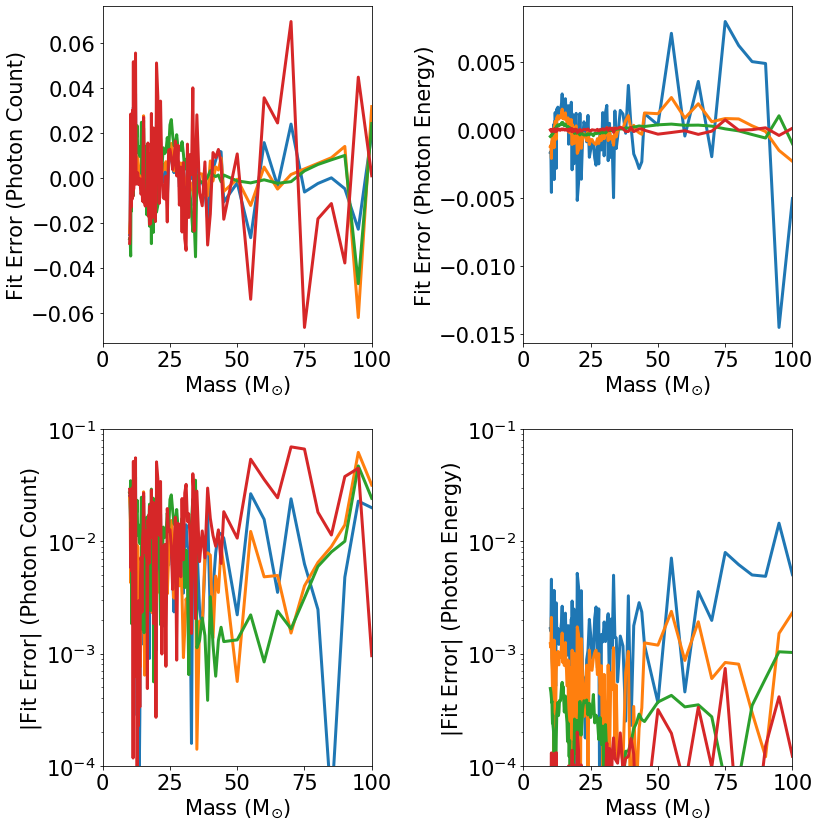

In [79]:

fig, all_ax = plt.subplots(2,2)
fig.set_size_inches(12,12)

ax = all_ax[0]

for radtype in ['HI','HeI','HeII','LW']:
    
    fit = all_fits['N_'+radtype]
    
    #print("Photons %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
    
    ax[0].plot(ionization_data['mass'], 
               fit.error, lw = 3, 
               color = colors[radtype], label = radtype)

    fit = all_fits['E_'+radtype]
          
    #print("Energy  %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
   
    ax[1].plot(ionization_data['mass'], fit.error, lw = 3,
               color = colors[radtype])

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[0].set_ylabel(r'Fit Error (Photon Count)')
ax[1].set_ylabel(r'Fit Error (Photon Energy)')


ax = all_ax[1]

for radtype in ['HI','HeI','HeII','LW']:
    
    fit = all_fits['N_'+radtype]
    
    #print("Photons %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
    
    ax[0].plot(ionization_data['mass'], 
               fit.abserror, lw = 3, 
               color = colors[radtype], label = radtype)

    fit = all_fits['E_'+radtype]
          
    #print("Energy  %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
   
    ax[1].plot(ionization_data['mass'], fit.abserror, lw = 3,
               color = colors[radtype])

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[0].set_ylabel(r'|Fit Error| (Photon Count)')
ax[1].set_ylabel(r'|Fit Error| (Photon Energy)')
ax[0].set_ylim(0.0001,0.1)
ax[1].set_ylim(ax[0].get_ylim())
ax[0].semilogy()
ax[1].semilogy()

#ax[0].legend(loc='best')

#ax[0].semilogy()
plt.tight_layout()

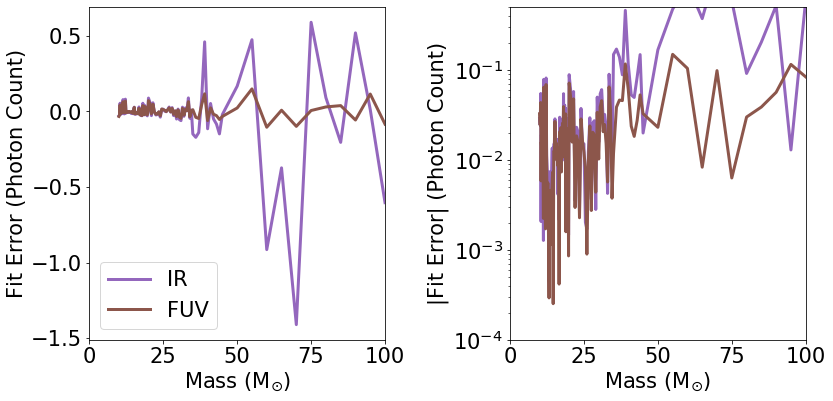

In [80]:

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)


for radtype in ["IR","FUV"]:
    
    fit = all_fits['N_'+radtype]
    
    #print("Photons %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
    
    ax[0].plot(ionization_data['mass'], 
               fit.error, lw = 3, 
               color = colors[radtype], label = radtype)

    #fit = all_fits['E_'+radtype]
          
    #print("Energy  %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
   
   # ax[1].plot(ionization_data['mass'], fit.error, lw = 3,
    #           color = colors[radtype])



ax[0].set_ylabel(r'Fit Error (Photon Count)')



for radtype in ["IR","FUV"]:
    
    fit = all_fits['N_'+radtype]
    
    #print("Photons %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
    
    ax[1].plot(ionization_data['mass'], 
               fit.abserror, lw = 3, 
               color = colors[radtype], label = radtype)

    #fit = all_fits['E_'+radtype]
          
    #print("Energy  %5s %5.2E %5.2E %5.2E"%(radtype, np.average(fit.abserror), np.min(fit.abserror), np.max(fit.abserror)))
   
    #ax[1].plot(ionization_data['mass'], fit.abserror, lw = 3,
    #           color = colors[radtype])

xlim=(0.0,100.0)
ax[0].set_xlabel(r'Mass (M$_{\odot}$)'); ax[0].set_xlim(xlim)
ax[1].set_xlabel(r'Mass (M$_{\odot}$)'); ax[1].set_xlim(xlim)


ax[1].set_ylabel(r'|Fit Error| (Photon Count)')
ax[1].set_ylim(0.0001,0.5)
ax[1].semilogy()

ax[0].legend(loc='best')

#ax[0].semilogy()
plt.tight_layout()

In [76]:
for name in all_fits:
    
    print(name)
    all_fits[name].output_to_code()

N_HI
2 polynomial fits made
3 degree over the range 1.00000E+01 <= x < 3.50000E+01
3 degree over the range 3.50000E+01 <= x < 1.00010E+02
= pow(10.0,  -1.2618e+00*x3 + 4.8613e+00*x2 -4.4976e+00*x1 + 6.3507e+01);
= pow(10.0,  1.6675e+00*x3 -9.1524e+00*x2 + 1.7875e+01*x1 + 5.1583e+01);
E_HI
1 polynomial fits made
= pow(10.0,  7.1694e-04*x3 -5.2935e-02*x2 + 2.5684e-01*x1 + 1.0847e+00);
N_HeI
2 polynomial fits made
3 degree over the range 1.00000E+01 <= x < 3.50000E+01
3 degree over the range 3.50000E+01 <= x < 1.00010E+02
= pow(10.0,  -1.0090e-01*x3 -2.2907e-01*x2 + 3.3247e+00*x1 + 5.8788e+01);
= pow(10.0,  4.1553e-01*x3 -2.8421e+00*x2 + 7.5444e+00*x1 + 5.6596e+01);
E_HeI
1 polynomial fits made
= pow(10.0,  -6.5004e-03*x3 + 5.8389e-03*x2 + 9.5175e-02*x1 + 1.3787e+00);
N_HeII
2 polynomial fits made
3 degree over the range 1.00000E+01 <= x < 3.50000E+01
3 degree over the range 3.50000E+01 <= x < 1.00010E+02
= pow(10.0,  3.7096e+00*x3 -1.6701e+01*x2 + 2.8367e+01*x1 + 4.3733e+01);
= pow(10.0,

In [89]:

def print_computephotonrates(radtype=['HI',"HeI","HeII","LW","IR","FUV"]):
    
    radnum = {'HI':0,'HeI':1,'HeII':2,'LW':3,"FUV":7,'IR':4}
   
    print("if ( fit_mass < mass_cut ){")
    for name in radtype:
        print("  Q[%i] "%(radnum[name]),end='')
        all_fits['N_' +name].output_to_code(fit_only=0,end='')
        print('')
    print("} else if (fit_mass <= 100.0) {")
    for name in radtype:
        print("  Q[%i] "%(radnum[name]),end='')
        all_fits['N_' +name].output_to_code(fit_only=1,end='')
        print('')
        
    print("} else {")
    print("  for (i=0;i<nbins;i++) Q[i]=0.0;")
    print("}")
    
    for name in radtype:
        if name in ['HI','HeI','HeII']:
            print("E[%i] "%(radnum[name]),end='')
            all_fits['E_'+name].output_to_code(fit_only=0,end='')
            print('')
            
    if 'LW' in radtype:
            print("E[%i] = LW_photon_energy;"%(radnum['LW']),end='')
            print('') 
    if 'IR' in radtype:
            print("E[%i] = IR_photon_energy;"%(radnum['IR']),end='')
            print('')
    if 'FUV' in radtype:
            # decreasing photon energy since this band is larger
            print("E[%i] = 0.8*FUV_photon_energy;"%(radnum['FUV']),end='')
            print('')               
        
    return

print_computephotonrates()

if ( fit_mass < mass_cut ){
  Q[0] = pow(10.0,  -1.2618e+00*x3 + 4.8613e+00*x2 -4.4976e+00*x + 6.3507e+01);
  Q[1] = pow(10.0,  -1.0090e-01*x3 -2.2907e-01*x2 + 3.3247e+00*x + 5.8788e+01);
  Q[2] = pow(10.0,  3.7096e+00*x3 -1.6701e+01*x2 + 2.8367e+01*x + 4.3733e+01);
  Q[3] = pow(10.0,  -1.8868e+00*x3 + 7.6565e+00*x2 -8.9860e+00*x + 6.5457e+01);
  Q[4] = pow(10.0,  -2.7242e+00*x3 + 1.1538e+01*x2 -1.5151e+01*x + 6.8400e+01);
  Q[7] = pow(10.0,  -2.3146e+00*x3 + 9.6461e+00*x2 -1.2168e+01*x + 6.7769e+01);
} else if (fit_mass <= 100.0) {
  Q[0] = pow(10.0,  1.6675e+00*x3 -9.1524e+00*x2 + 1.7875e+01*x + 5.1583e+01);
  Q[1] = pow(10.0,  4.1553e-01*x3 -2.8421e+00*x2 + 7.5444e+00*x + 5.6596e+01);
  Q[2] = pow(10.0,  3.1015e-01*x3 -3.1192e+00*x2 + 1.0218e+01*x + 5.1874e+01);
  Q[3] = pow(10.0,  4.7327e+00*x3 -2.5093e+01*x2 + 4.5244e+01*x + 3.5422e+01);
  Q[4] = pow(10.0,  -3.3190e+01*x3 + 1.7386e+02*x2 -2.9988e+02*x + 2.3327e+02);
  Q[7] = pow(10.0,  -1.3126e+00*x3 + 6.2667e+00*x2 -8.4472e+00*x 